# Lab 8: Graphical Models

The goal of this lab session is to code two methods to estimate the structure of undirected gaussian graphical models and compare them.

You have to send the filled notebook named **"L8_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before December 12, 2019 at 23:59 and put **"AML-L8"** as subject. 

We begin with the standard imports:

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.covariance import EmpiricalCovariance
import pywt

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## Graphical Models

A graphical model is a probabilistic model for which a graph expresses the conditional dependence structure between random variables. The variables are represented by nodes and the relations between them are represented by edges.

### GLasso

Graphical Lasso is the name of the optimization problem that estimates the precision matrix of a multivariate gaussian and its name comes from the direct link with graphical models and the regularization term. 

Fill in the following class that implements the GLasso algorithm optimized by ADMM:

In [77]:
class MyGraphicalLasso():
    
    def __init__(self, alpha, mu, max_iter = 60):
        '''
        Parameters:
        alpha : float
            Penalization parameter selected.
        mu: float>0

        Attributes:
        
        covariance_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.
        precision_ : numpy.ndarray, shape (n_features, n_features)
            Estimated precision matrix (inverse covariance).
        '''
        self.covariance_ = None
        self.precision_ = None
        self.alpha = alpha
        self.mu = mu
        self.max_iter = max_iter 
        
    def fit(self, X):
        """ Fits the GraphicalLasso model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """ 
        
        def f_v(x, mu):
            u, v = np.linalg.eig(x)
            return (0.5 * v@np.diag(u + np.sqrt(u**2 + (4/mu)))@v.T ) 
            
        # TODO:
        # initialize Y, Z
        # until convergence:
        #   Update precision
        #   Update Y
        #   Update Z
        X_mean = X.mean(0)
        cov = EmpiricalCovariance().fit(X)
        Y = np.linalg.inv(cov.covariance_)
        np.random.seed(0)
        Z = self.mu * np.random.rand(Y.shape[0], Y.shape[1])
        S = np.zeros((X.shape[1], X.shape[1]))
        for i in range(X.shape[0]):
            S += (X[i, :] - X_mean).reshape((X.shape[1], 1))@(X[i, :] - X_mean).reshape((X.shape[1], 1)).T
        S = (1/X.shape[0]) * S
        k = 0
        while k<self.max_iter:
            self.precision_ = f_v(Y - Z - (1/self.mu)*S, self.mu)
            #self.precision_ = self.precision_.astype(complex)
            Z = Z.astype(complex)
            Y = np.array(pywt.threshold(data=self.precision_+Z, value=self.alpha/self.mu, mode="soft"))
            Z += self.mu * (self.precision_ - Y)
            k += 1
        
        
        

Estimating the precision matrix from 60 samples... 



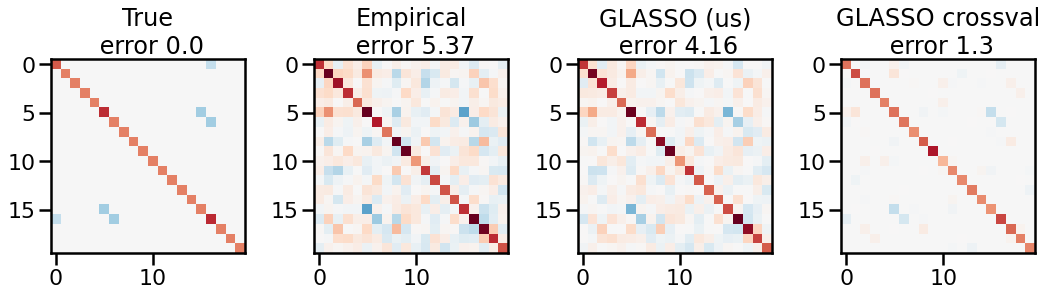

In [5]:
# Compare methods of estimating the covariance matrix in low-sample regime
n_samples = 60
n_features = 20

print(f'Estimating the precision matrix from {n_samples} samples... \n')


# Simulate data (multivariate gaussian)
from sklearn.datasets import make_sparse_spd_matrix
rng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, alpha=.98,
                              smallest_coef=.4,
                              largest_coef=.7,
                              random_state=rng)
cov = np.linalg.inv(prec)
mean = np.zeros(n_features)
data = np.random.multivariate_normal(mean, cov, n_samples)
err = np.linalg.norm(prec - prec)

prec_empirical = np.linalg.inv(np.dot(data.T, data) / n_samples)
err_empirical = np.linalg.norm(prec - prec_empirical)

# Graphical Lasso with cross validation 
from sklearn.covariance import GraphicalLassoCV
model = GraphicalLassoCV(cv=5)
model.fit(data)
prec_glassocv = model.precision_
err_glassocv = np.linalg.norm(prec - prec_glassocv)

# Graphical Lasso estimation using our implementation
model = MyGraphicalLasso(alpha=0.01, mu=0.1, max_iter=100)
model.fit(data)
prec_glasso = model.precision_
err_glasso = np.linalg.norm(prec - prec_glasso)
vmax = prec_glasso.max()


# Visual comparison
titles = ["True", "Empirical", "GLASSO (us)", "GLASSO crossval"]
imgs = [prec, prec_empirical, prec_glasso, prec_glassocv]
errors = [err, err_empirical, err_glasso, err_glassocv]

ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
for idx, ax in enumerate(axes.flatten()):
    img = imgs[idx]
    error = np.around(errors[idx], decimals=2)
    title = titles[idx] + f'\n error {error}'
    ax.imshow(img, vmin=-vmax, vmax=vmax, interpolation='nearest', cmap=plt.cm.RdBu_r)
    ax.set_title(title)
fig.tight_layout()




Comment on the different methods' ability to recover the precision matrix structure and what that means in terms of the graph between features. 

To generate our multivariate gaussian data we used a sparse precision matrix, then we inverted it to be used as a covariance matrix for data simulation. The sparsity of precision matrix means that most of the data gaussian points have zero inverse correlation between them, and since the data is gaussian this implies that most of that points are conditionally independant. This shows the importance of precision matrixes, because it make is a lot easier to test the conditional indepndance. Graphically, two data points $X_i$ and $X_j$ are conditionally independant if there is no edge $(i,j)$ between them. <br>
We can also visualize that on the precision matrix where on the original precision matrix only few data points (except the ones on the diagonal of course) are correlated. <br>
- The Empirical precision, is the inverse of the empirical covariance estimation $\hat \sigma = \frac {1}{n}.X^{T}.X$, where $X$ is our data, $n$ is the number of samples. This yields a recovering error of $5.37$. This means that more features are correlated and hence more data points are conditionally dependent compared to the truth.
- Our implemented Glasso yields a recovering error of $4.16$ : This may be explained by the fact that our penalization parameter $\alpha$ is not optimal to recover the precision matrix in the best way possible.
- GLASSO with crossval yields a recovering error of $1.3$ : We get the lowest error and best recovering of precision matrix. In fact, the iterative cross-validation process helps finding the optimal penalization parameter $\alpha$, which yields the best model. 

### Nodewise Regression

Fill in the following class that implements the nodewise regression algorithm to estimate a graphical model structure. You can use `LassoCV` for the regressions. Bonus (not graded): Implement your own cross-validation lasso.

In [6]:
from sklearn.linear_model import LassoCV

class my_nodewise_regression():
    
    def __init__(self, rule):
        '''
        Parameters:
        
        rule: {"OR", "AND"}
        
        Attributes:
        
        covariance_structure_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.        
        '''
        self.graph_structure_ = None
        self.rule = rule
        
    def fit(self, X):
        """ Fit the model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """         
        # TODO:
        # Estimate the precision structure
        # Symetrize with OR or AND rule
        
        S = []
        for j in range (X.shape[1]):
            reg = LassoCV(cv=5, random_state=0).fit(np.concatenate((X[:, :j], X[:, j+1:]), axis=1), X[:,j])
            coefs = reg.coef_
            coefs_j = np.zeros((X.shape[1]))
            coefs_j[j] = 0
            coefs_j[:j] = coefs[:j]
            coefs_j[j+1:] = coefs[j:]
            S.append(coefs_j)
        S = np.array(S)
        structure = np.zeros((X.shape[1], X.shape[1]))
        if self.rule == "AND":
            for k in range(X.shape[1]):
                for j in range(X.shape[1]):
                    structure[k,j] = int(S[k,j] != 0 and S[j,k] !=0)
        if self.rule == "OR":
            for k in range(X.shape[1]):
                for j in range(X.shape[1]):
                    structure[k,j] = int(S[k,j] != 0 or S[j,k] !=0)
        
#         for j in range(X.shape[1]):
#             for k in range(X.shape[1]):
                
        self.graph_structure_ = structure

Generate an easy-to-check (non-trivial, p<=6) example and plot the 4 (real, GLasso, AND, OR) graphs. You can use `networkx` to plot the resulting graph.

In [7]:
# TODO
from sklearn.datasets import make_gaussian_quantiles
real_cov = np.array([[0.8, 0.0, 0.2, 0.0],
                       [0.0, 0.4, 0.0, 0.0],
                        [0.2, 0.0, 0.3, 0.1],
                        [0.0, 0.0, 0.1, 0.7]])
rng = np.random.RandomState(0)
X = rng.multivariate_normal(mean=[0, 0, 0, 0],
                             cov=real_cov, size=500)

In [8]:
mod_OR = my_nodewise_regression("OR")
mod_OR.fit(X)
mod_AND = my_nodewise_regression("AND")
mod_AND.fit(X)

In [10]:
import networkx as nx

[0, 1, 2, 3]
[(0, 0), (0, 2), (1, 1), (2, 2), (2, 3), (3, 3)]


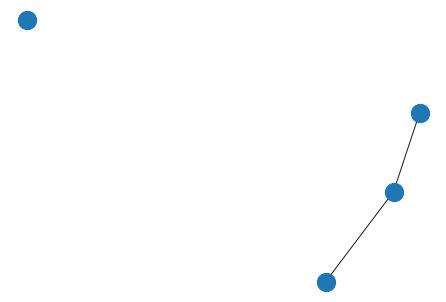

In [11]:
G_True = nx.from_numpy_matrix(real_cov)
print(G_True.nodes())
print(G_True.edges())
nx.draw(G_True)

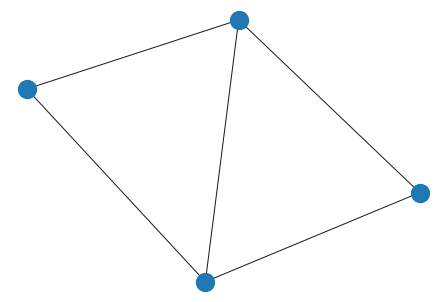

In [12]:
G_AND = nx.from_numpy_matrix(mod_OR.graph_structure_)
G_OR = nx.from_numpy_matrix(mod_AND.graph_structure_)
nx.draw(G_AND)

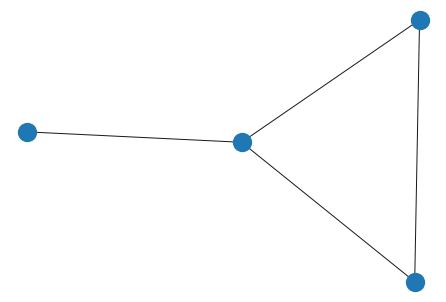

In [13]:
nx.draw(G_OR)

## Simulations

Compare the two graph estimators for each of the following models with $p = 300$ and $n = 40, 80, 320$:

- An AR(1)-Block model. In this model the *covariance* matrix is block-diagonal with equalsized AR(1)-blocks of the form $(\Sigma_{Block})_{i, j} = 0.9^{|i−j|}$, take $30 \times 30$ blocks.
- The exponential decay model considered in Fan et al. [2009]. In this model we consider a case where no element of the concentration matrix is exactly zero. The elements of $\Theta$ are given by $\Theta_{ij} = \exp{(−2|i − j|)}$ equals essentially zero when the difference |i − j| is large.

For GLasso estimation, use cross-validation k-fold with loglikelihood loss to select the $\lambda$ penalization parameter. Evaluate your estimation using the Froebenius matrix norm. 

For Node-regression estimation, compare your edge-estimation with the binary (thresholded) covariance matrix. Evaluate your estimation using accuracy and the F1 score. 

In [80]:
# TODO
#Model one : AR_Block Model 
#Block
block_size = 30
n_feature = 300 


block = np.ones((block_size, block_size))*1.
sigma = np.kron(np.eye(int(n_feature/block_size)),block)
for i in range(n_feature):
    for j in range(n_feature):
        if sigma[i,j]>0:
            sigma[i,j]=0.9**abs(i-j)
            
n_samples = 40
mean = np.zeros(n_feature)
data_AR = np.random.multivariate_normal(mean, sigma, n_samples)
    
    
    
    
#Model two: Exponential Decay 
#Concentration Matrix 
prec = np.zeros((n_feature, n_feature))
for i in range(n_feature):
    for j in range(n_feature):
        prec[i,j] = np.exp(-2*abs(i-j))
cov = np.linalg.inv(prec)
data_decay = np.random.multivariate_normal(mean, cov, n_samples)

#### Glasso Estimation  

In [86]:
n_samples = [40, 80, 320]
errors_ar = []
for n in n_samples:
    data_AR = np.random.multivariate_normal(mean, sigma, n)
    model_lasso = MyGraphicalLasso(alpha=0.01, mu=0.1, max_iter=100)
    model_lasso.fit(data_AR)
    prec_glasso = model_lasso.precision_
    err_glasso = np.linalg.norm(np.linalg.inv(sigma) - prec_glasso)
    errors_ar.append(err_glasso)

In [85]:
n_samples = [40, 80, 320]
errors_decay = []
for n in n_samples:
    data_decay = np.random.multivariate_normal(mean, cov, n)
    model_lasso = MyGraphicalLasso(alpha=0.01, mu=0.1, max_iter=100)
    model_lasso.fit(data_decay)
    prec_glasso = model_lasso.precision_
    err_glasso = np.linalg.norm(np.linalg.inv(cov) - prec_glasso)
    errors_decay.append(err_glasso)

In [138]:
pd.DataFrame(np.array([errors_ar,errors_decay]), columns=['40 samples','80 samples','320 samples'],index=['errors : AR','errors : decay'])

,40 samples,80 samples,320 samples
errors : AR,4.212222e+16,3.157299e+16,7986.249589
errors : decay,7.629120e+16,7.394425e+16,24.259888


#### Node Regressio 

In [111]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
n_samples = [40, 80, 320]
l_f1 = []
l_acc = []
for n in n_samples:
    data_AR = np.random.multivariate_normal(mean, sigma, n)
    mod_AND = my_nodewise_regression("AND")
    mod_AND.fit(data_AR)
    structure = mod_AND.graph_structure_
    binary_cov = (sigma != 0).astype(int)
    l_f1.append(f1_score(binary_cov.flatten(), structure.astype(int).flatten(), average='binary'))
    l_acc.append(accuracy_score(binary_cov.flatten(), structure.astype(int).flatten()))
    del data_AR


C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014963157173075602, tolerance: 0.0034137305148559606
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0049335389662454685, tolerance: 0.004230253133921133
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0042530928684907845, tolerance: 0.003920695690894391
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-pa

In [140]:
print("Node Regression with data AR")
pd.DataFrame(np.array([l_f1,l_acc]), columns=['40 samples','80 samples','320 samples'],index=['f1_score','accuracy'])

Node Regression with data AR


,40 samples,80 samples,320 samples
f1_score,0.151617,0.151899,0.153221
accuracy,0.905000,0.906200,0.907400


In [134]:
n_samples = [40, 80, 320]
l1_f1 = []
l1_acc = []
for n in n_samples:
    data_decay = np.random.multivariate_normal(mean, cov, n)
    mod_AND = my_nodewise_regression("AND")
    mod_AND.fit(data_decay)
    structure = mod_AND.graph_structure_
    binary_cov = (cov != 0).astype(int)
    l1_f1.append(f1_score(binary_cov.flatten(), structure.astype(int).flatten(), average='binary'))
    l1_acc.append(accuracy_score(binary_cov.flatten(), structure.astype(int).flatten()))
    del data_decay
    

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006589331470188542, tolerance: 0.004353351637634395
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010607251981643522, tolerance: 0.004575234487257207
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005074598398048787, tolerance: 0.002615735040620885
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packa

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031193252551988182, tolerance: 0.026314587954723658
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032340807712674335, tolerance: 0.026314587954723658
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0324001299165817, tolerance: 0.025425581845261277
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0247908223312292, tolerance: 0.023798664157614953
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024126239513108938, tolerance: 0.023798664157614953
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02441582596008318, tolerance: 0.022848846722147056
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024236420669755065, tolerance: 0.020311014007779894
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02050004960824925, tolerance: 0.020311014007779894
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020786752108937545, tolerance: 0.020311014007779894
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027066277109037418, tolerance: 0.025368667991742637
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030855126230330543, tolerance: 0.025688849582373576
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0298596604086514, tolerance: 0.02490853885842807
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029616621184506364, tolerance: 0.022472722723621018
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02565829583283019, tolerance: 0.022472722723621018
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024367549492457563, tolerance: 0.022472722723621018
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028299869598794825, tolerance: 0.025923633537541516
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028765272518878504, tolerance: 0.025923633537541516
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031225438998138566, tolerance: 0.025923633537541516
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packa

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.055939278620391164, tolerance: 0.030134510269204273
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04708602191261746, tolerance: 0.030134510269204273
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03923443475814592, tolerance: 0.030134510269204273
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027120634622405715, tolerance: 0.025634523299054877
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028770715012303105, tolerance: 0.027495997440116122
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03148881946652837, tolerance: 0.027495997440116122
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03363791955682438, tolerance: 0.02901154924324084
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03012336894716966, tolerance: 0.02901154924324084
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031276443560720346, tolerance: 0.02901154924324084
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030148367100779394, tolerance: 0.029740305785281113
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030106448291492893, tolerance: 0.029740305785281113
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031030451382558444, tolerance: 0.029740305785281113
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packa

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02970525918332001, tolerance: 0.024289380515778426
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04045153605688445, tolerance: 0.024289380515778426
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037132114318102594, tolerance: 0.024289380515778426
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030221345615760953, tolerance: 0.022318029526482732
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.038317085873982526, tolerance: 0.022318029526482732
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033145704311114965, tolerance: 0.022318029526482732
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packa

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02561678230366382, tolerance: 0.02505878846404397
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03823509758772525, tolerance: 0.02635725275331281
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02685447265512042, tolerance: 0.02635725275331281
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03471316169568184, tolerance: 0.023559585375004275
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0371116445766273, tolerance: 0.023559585375004275
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03458081291799586, tolerance: 0.023559585375004275
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0265139119068821, tolerance: 0.0259532107907435
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029084966399107237, tolerance: 0.0259532107907435
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.052592395053626784, tolerance: 0.03026219625335756
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\skl

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03024989906906933, tolerance: 0.027542467091330812
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028791646252047887, tolerance: 0.02764483435393613
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02915552386716147, tolerance: 0.02764483435393613
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04109101794847836, tolerance: 0.03082702329031222
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0465303855575212, tolerance: 0.03082702329031222
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.039658905231931274, tolerance: 0.03082702329031222
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03511072972878959, tolerance: 0.028900225752875795
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03758956959664339, tolerance: 0.028900225752875795
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03295440173203945, tolerance: 0.028900225752875795
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.046218377126712396, tolerance: 0.022743373937370616
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024276228871446648, tolerance: 0.022743373937370616
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02583011427614834, tolerance: 0.02325957098411426
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026397855028950534, tolerance: 0.023974660505326276
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028185151650900353, tolerance: 0.023974660505326276
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023989589970309755, tolerance: 0.023974660505326276
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packa

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03489890528293549, tolerance: 0.023903015771498785
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03177427578009734, tolerance: 0.023903015771498785
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.038570192672351816, tolerance: 0.023903015771498785
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031195418482069304, tolerance: 0.028583088123859984
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028860957972557055, tolerance: 0.028583088123859984
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029996241574931637, tolerance: 0.029321356473259303
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packa

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.039982155308152745, tolerance: 0.02785458182217982
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03910916914319462, tolerance: 0.02785458182217982
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03348134898476829, tolerance: 0.02785458182217982
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03564443025921438, tolerance: 0.02917956699457905
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030590206943630127, tolerance: 0.02917956699457905
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032502546271270916, tolerance: 0.02917956699457905
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03678877491560595, tolerance: 0.028509387673548783
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032637160267483756, tolerance: 0.028509387673548783
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03146384850773898, tolerance: 0.028509387673548783
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.041391363785132196, tolerance: 0.0264832839180937
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05888115294726326, tolerance: 0.0264832839180937
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04804933109107634, tolerance: 0.0264832839180937
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\skle

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024964274003600823, tolerance: 0.023524142976200337
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028180148789841042, tolerance: 0.02594479025611524
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028413587883820424, tolerance: 0.024347954581117517
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027839287649698077, tolerance: 0.027277237975831578
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027145552297588027, tolerance: 0.02255449009178911
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025544397848917433, tolerance: 0.02255449009178911
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029036576233716693, tolerance: 0.027689010399996734
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028638065987770633, tolerance: 0.027689010399996734
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028177432151745424, tolerance: 0.027689010399996734
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packa

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032464938123678955, tolerance: 0.025725643481118006
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0248596026233181, tolerance: 0.02454616053617297
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031042929384333617, tolerance: 0.022910966834917525
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03844202124049634, tolerance: 0.02465598347554005
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029932816553239983, tolerance: 0.02465598347554005
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02924658541396008, tolerance: 0.02465598347554005
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02926040574491162, tolerance: 0.027336117903157015
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030254503751828088, tolerance: 0.027336117903157015
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02752300233871935, tolerance: 0.027336117903157015
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0405025730290689, tolerance: 0.022816576755702735
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025731780789327918, tolerance: 0.022816576755702735
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02311584912082626, tolerance: 0.022816576755702735
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03416598714823804, tolerance: 0.025348284934906967
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029231718106631832, tolerance: 0.025348284934906967
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02988974436079428, tolerance: 0.024561062343952715
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03818852364327885, tolerance: 0.026592150897423075
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030759353356383135, tolerance: 0.026592150897423075
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03434414413990261, tolerance: 0.03008494120975754
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030295241443541343, tolerance: 0.0262377667272984
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02815343208541843, tolerance: 0.0262377667272984
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02676132300491174, tolerance: 0.0262377667272984
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\skle

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03980072784838673, tolerance: 0.030213437553410008
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05485776371420603, tolerance: 0.030213437553410008
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0343370862741208, tolerance: 0.030213437553410008
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03643831850280643, tolerance: 0.027108253554578188
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0371979680749015, tolerance: 0.027108253554578188
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027659960960123797, tolerance: 0.027108253554578188
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030333326846072595, tolerance: 0.028698565541548683
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0353698165760753, tolerance: 0.028698565541548683
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03553470756722943, tolerance: 0.028698565541548683
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02474144184448468, tolerance: 0.024627071703527202
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028002463865707206, tolerance: 0.024627071703527202
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.040015706593653, tolerance: 0.024627071703527202
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05353767797437614, tolerance: 0.029127269558265823
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05218785613649879, tolerance: 0.029127269558265823
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03481458254928893, tolerance: 0.029127269558265823
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03970268231680529, tolerance: 0.03005518492745609
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03900920590667667, tolerance: 0.030734650116252853
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036030325321046774, tolerance: 0.030734650116252853
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03958548568403408, tolerance: 0.031064190072070588
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03304803519218624, tolerance: 0.029355068455603716
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.055474089493062984, tolerance: 0.030349505771623285
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02901820866590271, tolerance: 0.025101605493830247
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030865045004440983, tolerance: 0.024634185690515113
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027977767436834222, tolerance: 0.024634185690515113
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04537671822631939, tolerance: 0.028607969378558383
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037811841285260606, tolerance: 0.028607969378558383
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05743855835928979, tolerance: 0.028607969378558383
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03413261898948883, tolerance: 0.02752305060165573
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03873193944241993, tolerance: 0.02752305060165573
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027458925977866366, tolerance: 0.026911687371471534
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03194457718437782, tolerance: 0.025069505028729372
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04265724621646205, tolerance: 0.025069505028729372
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04571159991736229, tolerance: 0.025069505028729372
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03507428365331977, tolerance: 0.024221683598710003
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0251453821851233, tolerance: 0.024221683598710003
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026860561651603554, tolerance: 0.024221683598710003
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04422793838485051, tolerance: 0.025300023581402934
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04044347304572615, tolerance: 0.025300023581402934
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029594707352187388, tolerance: 0.025300023581402934
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03185636622701171, tolerance: 0.02593945054559189
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0554586484828099, tolerance: 0.02593945054559189
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03795261705557884, tolerance: 0.028024457971646724
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03605064025754451, tolerance: 0.02554538831685371
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.042559082602047216, tolerance: 0.02554538831685371
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026766713923759677, tolerance: 0.02554538831685371
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030501127031884234, tolerance: 0.02922430240679593
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034753475077230256, tolerance: 0.030905794320909254
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03448540560783808, tolerance: 0.030905794320909254
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028445797427509634, tolerance: 0.027160456536669545
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03798046659260687, tolerance: 0.027160456536669545
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02768915580406514, tolerance: 0.027160456536669545
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029308227941049037, tolerance: 0.024311133782823256
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02629490575792298, tolerance: 0.026083166817087205
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028174365147437375, tolerance: 0.026083166817087205
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03349624114572464, tolerance: 0.03304899285107931
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0412623113279596, tolerance: 0.032338885362711824
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03835552775547402, tolerance: 0.03151159836850423
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04165004382653548, tolerance: 0.028468445658996554
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.057085270756922046, tolerance: 0.028468445658996554
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029274260615956393, tolerance: 0.028468445658996554
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029627144551888196, tolerance: 0.02923802465154241
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03768279395726104, tolerance: 0.026424086598506633
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05376993190538837, tolerance: 0.026424086598506633
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0333515688237509, tolerance: 0.02870315921573134
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03476638523999087, tolerance: 0.02870315921573134
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030334705693285224, tolerance: 0.02870315921573134
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03374615333718878, tolerance: 0.029966398061523684
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027888223519953015, tolerance: 0.027362033558103203
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0322427683494291, tolerance: 0.027362033558103203
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032456917723083234, tolerance: 0.030423014721574253
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033707795738636526, tolerance: 0.030423014721574253
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03173969393813664, tolerance: 0.030423014721574253
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031004088083745607, tolerance: 0.026183258675147297
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026193345048646455, tolerance: 0.026183258675147297
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03119981553938983, tolerance: 0.025771863945895836
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030772481499685034, tolerance: 0.02393121130055776
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0389416180864699, tolerance: 0.02393121130055776
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03651524152325525, tolerance: 0.02393121130055776
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03178745073784153, tolerance: 0.025060818645907243
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02756926139424043, tolerance: 0.025781868269936902
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03589219750795336, tolerance: 0.025781868269936902
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03153066281781369, tolerance: 0.02585263604337566
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03408498241995733, tolerance: 0.02585263604337566
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03174045866512082, tolerance: 0.02585263604337566
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03004627834073864, tolerance: 0.027691131296019866
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028529337567267943, tolerance: 0.027691131296019866
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03474237094142918, tolerance: 0.02652783120317396
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029254887118248085, tolerance: 0.02858854929015787
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032842111033974275, tolerance: 0.02858854929015787
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03369703713745659, tolerance: 0.02858854929015787
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03328153199726658, tolerance: 0.02214242850835703
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037817122001463366, tolerance: 0.02214242850835703
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022464220369515592, tolerance: 0.02214242850835703
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03557966256196274, tolerance: 0.027540957240218992
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027158855536660642, tolerance: 0.025827964450672414
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02738013086692004, tolerance: 0.025827964450672414
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027293703189628205, tolerance: 0.026997489636659766
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03040787533924716, tolerance: 0.026997489636659766
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03521610619529203, tolerance: 0.026997489636659766
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026264909094647404, tolerance: 0.025522291811868807
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032000828704919826, tolerance: 0.026507265451227613
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028482468102979552, tolerance: 0.026507265451227613
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packa

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030907690141998456, tolerance: 0.021854507122392928
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029795005703844857, tolerance: 0.022920525810588652
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027783919580634697, tolerance: 0.022920525810588652
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packa

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.049901070081568744, tolerance: 0.029233438489796756
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06755789819685454, tolerance: 0.029233438489796756
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03857852970199893, tolerance: 0.029233438489796756
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04221565404597438, tolerance: 0.028063928451580872
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03047403600045273, tolerance: 0.028063928451580872
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030515459347082885, tolerance: 0.028063928451580872
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033777784717235915, tolerance: 0.030107749960746652
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03859231234605509, tolerance: 0.030107749960746652
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03057564854974415, tolerance: 0.030107749960746652
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02978071700105045, tolerance: 0.025805180029111932
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028162684202229116, tolerance: 0.025805180029111932
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0382502072817994, tolerance: 0.025805180029111932
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03721184804834521, tolerance: 0.024843945519554395
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025100560546189588, tolerance: 0.024843945519554395
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037105927616317924, tolerance: 0.026219567667145272
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03547578890589431, tolerance: 0.028180084467779865
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0470689220132916, tolerance: 0.028180084467779865
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0639700949414288, tolerance: 0.028180084467779865
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03034135778259639, tolerance: 0.028787553751358493
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.042338371255295826, tolerance: 0.026825852694219193
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030264901519679088, tolerance: 0.026825852694219193
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032037265756847066, tolerance: 0.027216860760657224
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04221410766938671, tolerance: 0.02617485633026172
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036742970349283866, tolerance: 0.02617485633026172
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037772453032865916, tolerance: 0.026320558498391797
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03279494916611325, tolerance: 0.026320558498391797
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02811442058533148, tolerance: 0.026320558498391797
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035629628190052554, tolerance: 0.024888700463792022
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03512526671148031, tolerance: 0.024888700463792022
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036434201316410064, tolerance: 0.024888700463792022
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030546882622227378, tolerance: 0.025087045732446935
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03577976688185425, tolerance: 0.029584477676899448
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05431080588273063, tolerance: 0.029584477676899448
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03277405844870884, tolerance: 0.026068599021310115
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02467466341237734, tolerance: 0.023217874874288225
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02456341608204679, tolerance: 0.023217874874288225
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029263128785779968, tolerance: 0.025767711452213963
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02963585610614511, tolerance: 0.025767711452213963
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025887655714889823, tolerance: 0.025767711452213963
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022687293424886956, tolerance: 0.02173264041782638
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025855883357934983, tolerance: 0.02173264041782638
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02272958444561246, tolerance: 0.02173264041782638
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03091379486405238, tolerance: 0.023752623825298087
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02505148860764375, tolerance: 0.023752623825298087
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027376082564976034, tolerance: 0.026151898695719808
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034475769466008416, tolerance: 0.026793011284729596
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032897718429054396, tolerance: 0.026793011284729596
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030335513801824088, tolerance: 0.026793011284729596
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packa

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024491276068772105, tolerance: 0.02053434994091336
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025505349283833856, tolerance: 0.02053434994091336
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029861124103416903, tolerance: 0.02053434994091336
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028635510654249297, tolerance: 0.025483853719358737
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03503191201353273, tolerance: 0.025483853719358737
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03317639987763876, tolerance: 0.025483853719358737
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028111535467608473, tolerance: 0.02658939217731862
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027747478307065254, tolerance: 0.02658939217731862
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031787317293820117, tolerance: 0.02658939217731862
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.048796237673165654, tolerance: 0.024713048278174957
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02542182623979805, tolerance: 0.024713048278174957
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03919353008655213, tolerance: 0.024713048278174957
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03272439012532391, tolerance: 0.027728458557079467
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033059484127209826, tolerance: 0.027728458557079467
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03150417938744132, tolerance: 0.026699614263974252
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02569047089301635, tolerance: 0.024959181295618242
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025432812508265096, tolerance: 0.024959181295618242
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03420569027177611, tolerance: 0.02410252144603783
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03294127414721437, tolerance: 0.025312897751959863
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030010102549112183, tolerance: 0.025312897751959863
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027247058432498306, tolerance: 0.025312897751959863
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04017289834333415, tolerance: 0.02832078800982554
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03166607097395724, tolerance: 0.02832078800982554
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03425855146114101, tolerance: 0.02832078800982554
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03245759965354067, tolerance: 0.027657202232428194
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03872812769012779, tolerance: 0.027657202232428194
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030189578154798752, tolerance: 0.02815006262425888
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.041992350699605496, tolerance: 0.02592994557181939
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03509544104063461, tolerance: 0.02592994557181939
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03192978595456272, tolerance: 0.02592994557181939
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03501851082108853, tolerance: 0.025198234966569404
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027429009156142548, tolerance: 0.025198234966569404
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029253351217187196, tolerance: 0.025198234966569404
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02859993292081242, tolerance: 0.027865150503911505
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037100930699404344, tolerance: 0.027865150503911505
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030867950895307583, tolerance: 0.027865150503911505
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04265854810250369, tolerance: 0.023934649989035793
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0361276204441332, tolerance: 0.023934649989035793
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025888389782812715, tolerance: 0.023934649989035793
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027933314865650302, tolerance: 0.025691390735523987
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02647315622696822, tolerance: 0.025691390735523987
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023947971328046436, tolerance: 0.022709701694750034
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03171603240328058, tolerance: 0.027536438053174527
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0326558373245982, tolerance: 0.02751992492358503
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034043628486077004, tolerance: 0.02751992492358503
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02946407048265476, tolerance: 0.025339828414915732
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028217249898220942, tolerance: 0.02464370857171037
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029431402848036692, tolerance: 0.02464370857171037
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027336372535999853, tolerance: 0.026592924286136684
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02842796970487671, tolerance: 0.026592924286136684
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03768596967157889, tolerance: 0.026592924286136684
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03616502680971223, tolerance: 0.027807957903743002
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04061439996549665, tolerance: 0.027807957903743002
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029179598415908226, tolerance: 0.027807957903743002
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02876223273766154, tolerance: 0.0264239174249692
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02772415764605307, tolerance: 0.0264239174249692
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026956767943109416, tolerance: 0.0264239174249692
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\skle

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0314262733356615, tolerance: 0.027727091025049857
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03851925763050143, tolerance: 0.027727091025049857
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02914695440940049, tolerance: 0.027727091025049857
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023840315888531416, tolerance: 0.021903898900052968
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03816212601619107, tolerance: 0.028288346795699387
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02858329910317048, tolerance: 0.028288346795699387
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03680993280818878, tolerance: 0.02427205014639151
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02639727655749491, tolerance: 0.02427205014639151
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03456677766477356, tolerance: 0.02427205014639151
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03662550561413602, tolerance: 0.0320388151357551
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03973991747975636, tolerance: 0.03447510851943686
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032444180857282956, tolerance: 0.03194196100940789
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02320106486122475, tolerance: 0.02272851708563564
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02434564613296253, tolerance: 0.02272851708563564
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034506166947990025, tolerance: 0.028453205775529945
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026683496659416717, tolerance: 0.023564577193190724
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025720498998865082, tolerance: 0.023564577193190724
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03097366254581324, tolerance: 0.023564577193190724
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02945619412569085, tolerance: 0.02232095944169327
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034194805591593644, tolerance: 0.02232095944169327
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030956655873138894, tolerance: 0.024164172424174537
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03475778121240114, tolerance: 0.027947632721812735
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04942663142199599, tolerance: 0.027947632721812735
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06387804792372065, tolerance: 0.027947632721812735
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024207973901367086, tolerance: 0.022878416996356364
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02765892503061751, tolerance: 0.022878416996356364
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03064184600403219, tolerance: 0.022878416996356364
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029614901435440544, tolerance: 0.02624448458325465
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04661234029974004, tolerance: 0.02624448458325465
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0754431842989769, tolerance: 0.02624448458325465
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05076533080507817, tolerance: 0.02506710937680202
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02984382314891776, tolerance: 0.02506710937680202
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025541574803331385, tolerance: 0.02506710937680202
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026887844137511774, tolerance: 0.02471628947849033
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028488727895761512, tolerance: 0.02471628947849033
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027099480389691066, tolerance: 0.02471628947849033
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03812787619087388, tolerance: 0.027547586258422848
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.038886067216204134, tolerance: 0.027547586258422848
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028221045428286295, tolerance: 0.027547586258422848
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02790085976716683, tolerance: 0.02541880837835465
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03200088796871281, tolerance: 0.02541880837835465
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032798279737010994, tolerance: 0.02541880837835465
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03039800979615004, tolerance: 0.03037883862287978
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04098947783732165, tolerance: 0.03037883862287978
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04657091958943593, tolerance: 0.03037883862287978
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03227263392317148, tolerance: 0.025678260465341447
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03502088993868632, tolerance: 0.025678260465341447
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032561736239634376, tolerance: 0.025678260465341447
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031298456872911995, tolerance: 0.025003989032108723
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03620394039482644, tolerance: 0.025003989032108723
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0256644495501277, tolerance: 0.025003989032108723
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025015816249831055, tolerance: 0.02449927825181548
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025653540772776484, tolerance: 0.025107838547619343
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03164443613459755, tolerance: 0.025134087017661767
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03653230101318103, tolerance: 0.02493475162919628
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028128276541684594, tolerance: 0.025181788616143865
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03440015608839664, tolerance: 0.025181788616143865
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026098772455528607, tolerance: 0.02537225236324393
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025419353474639084, tolerance: 0.02537225236324393
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02824513555237429, tolerance: 0.02537225236324393
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02901555021481106, tolerance: 0.027991194573563565
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03638890549090357, tolerance: 0.027991194573563565
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035727607331973, tolerance: 0.027991194573563565
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02808623740468974, tolerance: 0.026864205809016592
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030900749372092084, tolerance: 0.026864205809016592
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031321151410447445, tolerance: 0.029475704933241923
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03186204554605765, tolerance: 0.027218454189946624
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03919811432999332, tolerance: 0.027062615340807446
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03485597758271464, tolerance: 0.027062615340807446
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031043780536911925, tolerance: 0.026159757971538446
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03349175674177629, tolerance: 0.026159757971538446
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036627889429466154, tolerance: 0.026159757971538446
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02821780442810551, tolerance: 0.02228792988784257
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030849866942027737, tolerance: 0.02228792988784257
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02249320202834404, tolerance: 0.02228792988784257
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026967330176752125, tolerance: 0.022215100658038292
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029178802555290595, tolerance: 0.022215100658038292
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030629243937239314, tolerance: 0.022215100658038292
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packa

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030442982057226953, tolerance: 0.02696610904083233
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0298572931890142, tolerance: 0.02696610904083233
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02801900807255897, tolerance: 0.02696610904083233
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021826260790503205, tolerance: 0.021600059550932287
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024848214489044784, tolerance: 0.021600059550932287
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030916433806515098, tolerance: 0.022294685527074642
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packa

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023463734774731515, tolerance: 0.021954495431147757
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02237208018967396, tolerance: 0.021954495431147757
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024157547023407666, tolerance: 0.020091616444446066
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02721059943690507, tolerance: 0.026665816685240238
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0332689581849841, tolerance: 0.028578281623232126
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02909922589620806, tolerance: 0.028578281623232126
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02851167371528479, tolerance: 0.024746308672680333
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02895657645203481, tolerance: 0.024746308672680333
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028132828581307556, tolerance: 0.024746308672680333
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02830681947863045, tolerance: 0.02672657324909409
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026932900378436653, tolerance: 0.02672657324909409
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027083410315944967, tolerance: 0.02672657324909409
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02966731357111535, tolerance: 0.027964880847377027
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03080509231284631, tolerance: 0.027384672887995634
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03130087816835936, tolerance: 0.027384672887995634
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03867343512508503, tolerance: 0.03286521265759196
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03980980577727378, tolerance: 0.03286521265759196
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.045869765997517575, tolerance: 0.03286521265759196
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028273493072560663, tolerance: 0.02797269090591874
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04473392039442037, tolerance: 0.02797269090591874
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04369642062608636, tolerance: 0.02797269090591874
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03168809683877177, tolerance: 0.028443018514316864
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029823640961773812, tolerance: 0.0274718171628787
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0337550381223255, tolerance: 0.0274718171628787
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\skl

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030497483153330895, tolerance: 0.02528501416309388
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04483147326593362, tolerance: 0.02528501416309388
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027047041230106927, tolerance: 0.02528501416309388
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04049733415969792, tolerance: 0.03239469724780994
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04648586433356883, tolerance: 0.03239469724780994
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05233434234222356, tolerance: 0.03239469724780994
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03402066243581103, tolerance: 0.02593157065229833
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027879446561078325, tolerance: 0.02593157065229833
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027245614621070224, tolerance: 0.02593157065229833
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.038716113179493195, tolerance: 0.026310146954715185
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04255299778510857, tolerance: 0.026310146954715185
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02907273380725106, tolerance: 0.026310146954715185
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.054118091591658035, tolerance: 0.027898497160646747
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.054632145128995724, tolerance: 0.027898497160646747
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04240949115692827, tolerance: 0.027898497160646747
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033412674771821305, tolerance: 0.026758179602635337
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03980262260459433, tolerance: 0.026758179602635337
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029415147353374194, tolerance: 0.026758179602635337
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03813050530676332, tolerance: 0.023265564566666043
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026395440770967782, tolerance: 0.023265564566666043
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028356153403324758, tolerance: 0.023265564566666043
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03782149880151131, tolerance: 0.02597506242768368
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03920072673000763, tolerance: 0.02597506242768368
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026094922244439545, tolerance: 0.02597506242768368
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03026082583282652, tolerance: 0.026126253181642984
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02755538234788349, tolerance: 0.026126253181642984
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032014395468738854, tolerance: 0.02840122610189984
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.045197125429934815, tolerance: 0.030846805342715083
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035672850005775025, tolerance: 0.030846805342715083
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.052629994218385434, tolerance: 0.030846805342715083
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packa

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0283639968010011, tolerance: 0.026569241134892157
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03375713270892511, tolerance: 0.028084428360619137
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04165730801760481, tolerance: 0.028084428360619137
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02319231583665382, tolerance: 0.022798055750983686
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03039824415465886, tolerance: 0.02579660211655606
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02682688101994335, tolerance: 0.02579660211655606
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03136770982078624, tolerance: 0.024078624093922595
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03143200593454398, tolerance: 0.024078624093922595
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024685573156204788, tolerance: 0.024078624093922595
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030498663499988532, tolerance: 0.028608636551553015
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03653862392540841, tolerance: 0.03051333703039318
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03767462754338091, tolerance: 0.03051333703039318
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04058635219681894, tolerance: 0.02275629754063731
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0288826262108135, tolerance: 0.02275629754063731
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024395059794089402, tolerance: 0.02275629754063731
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035841081567487, tolerance: 0.028298514737119695
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03214319408028299, tolerance: 0.028298514737119695
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03479791149401734, tolerance: 0.028298514737119695
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031472962055632714, tolerance: 0.028521271680713608
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027036686272270516, tolerance: 0.02554138958633107
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03921730049431993, tolerance: 0.028017599553661364
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04133123196995303, tolerance: 0.025668859452763263
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028203928083234242, tolerance: 0.025668859452763263
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03244997544556827, tolerance: 0.025668859452763263
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029769998747187, tolerance: 0.025199157563510814
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025442102884857765, tolerance: 0.024219361112033877
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027692701935971092, tolerance: 0.024219361112033877
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026607172848256422, tolerance: 0.025682590165749003
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027189467643599585, tolerance: 0.02623087210889118
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025472481813665127, tolerance: 0.024018246532044964
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03844121862688793, tolerance: 0.03265391306675147
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03471943954858625, tolerance: 0.03265391306675147
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.045199135309467564, tolerance: 0.03265391306675147
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.044996465765519744, tolerance: 0.02820882700815663
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034546299433694694, tolerance: 0.02820882700815663
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03004721624011797, tolerance: 0.02820882700815663
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02862715595860532, tolerance: 0.025920201873718022
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.049042515982210766, tolerance: 0.025920201873718022
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06584905180889056, tolerance: 0.025920201873718022
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03287230692798371, tolerance: 0.028790772773472896
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03235012292110473, tolerance: 0.027930944478038407
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0302367729433608, tolerance: 0.027662204318760406
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028946342489724608, tolerance: 0.027986523354608325
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.045098417537615454, tolerance: 0.02746670472996756
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.045888170792882654, tolerance: 0.02746670472996756
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028988898909479796, tolerance: 0.02461086235106313
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026179224615881763, tolerance: 0.02461086235106313
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0262676428668088, tolerance: 0.02461086235106313
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03479962359555522, tolerance: 0.026992454658270125
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03825169671599582, tolerance: 0.026992454658270125
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03514028792701751, tolerance: 0.026992454658270125
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03347102364456722, tolerance: 0.02201861343453262
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03052145038862486, tolerance: 0.02201861343453262
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03260011852960454, tolerance: 0.02201861343453262
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03740262154435969, tolerance: 0.024714504277895216
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029692910783152227, tolerance: 0.024714504277895216
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03280630213177427, tolerance: 0.024714504277895216
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029526002194203205, tolerance: 0.025225529734946937
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02595238550741108, tolerance: 0.025225529734946937
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03201815803684083, tolerance: 0.025225529734946937
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028946769181752763, tolerance: 0.02672017049811649
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029356493468999822, tolerance: 0.02672017049811649
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026736819374972964, tolerance: 0.02672017049811649
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034786110283915095, tolerance: 0.02833288501279891
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04045922934909754, tolerance: 0.02833288501279891
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030370352600723183, tolerance: 0.027162083112547447
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04546572879274047, tolerance: 0.02989149493522639
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03632517115511691, tolerance: 0.02989149493522639
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035246143514695794, tolerance: 0.02989149493522639
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033668806678580965, tolerance: 0.027703787730167455
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02812980199515558, tolerance: 0.027703787730167455
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03085726253941168, tolerance: 0.028737688194121248
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03982696518233886, tolerance: 0.025491819033426868
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04200884802308075, tolerance: 0.025491819033426868
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.039232496787827364, tolerance: 0.025491819033426868
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05212352111179408, tolerance: 0.026764261738353175
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034148878225622514, tolerance: 0.026764261738353175
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03286437852340729, tolerance: 0.026764261738353175
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024915091457054173, tolerance: 0.02392651277251506
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02744246190020272, tolerance: 0.024380512010901648
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03405667750058505, tolerance: 0.024380512010901648
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03171014044778353, tolerance: 0.02834215691059028
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.039674970995093095, tolerance: 0.02834215691059028
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034810935046714286, tolerance: 0.02834215691059028
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04188346022525513, tolerance: 0.024250425625080146
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03228301474299089, tolerance: 0.024250425625080146
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035479806466502284, tolerance: 0.024250425625080146
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03845343723222783, tolerance: 0.028921854356278233
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03264279969535111, tolerance: 0.028921854356278233
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03555262331560893, tolerance: 0.028921854356278233
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036882667647891054, tolerance: 0.027248931723080103
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03219149048953587, tolerance: 0.027248931723080103
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03715745838468454, tolerance: 0.026966866332657664
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03836591432823777, tolerance: 0.028622735093170936
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029745715369631, tolerance: 0.02837422189917235
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02842977597242767, tolerance: 0.02837422189917235
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\skl

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031863810890559924, tolerance: 0.028741058364055126
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033194817591865516, tolerance: 0.028741058364055126
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032082735536117846, tolerance: 0.028741058364055126
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packa

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02613139252290919, tolerance: 0.02562776769868615
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03114986060100078, tolerance: 0.02562776769868615
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037612759158647924, tolerance: 0.02562776769868615
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03406597013967949, tolerance: 0.027490795552481042
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02564569755135987, tolerance: 0.025620289876945833
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029936514239634338, tolerance: 0.025620289876945833
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027590042681412963, tolerance: 0.025160084876403584
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03628602164367711, tolerance: 0.025160084876403584
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.045577099400486376, tolerance: 0.025160084876403584
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02504188252722994, tolerance: 0.022150853452329238
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026838238868291953, tolerance: 0.023765933898156306
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024092702396477872, tolerance: 0.023765933898156306
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035194407183240184, tolerance: 0.02553243929478473
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0362944723948857, tolerance: 0.02553243929478473
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03139385518589677, tolerance: 0.02553243929478473
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sk

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03683614108072264, tolerance: 0.024499484617931645
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03121730297694897, tolerance: 0.024499484617931645
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03210546918776441, tolerance: 0.024499484617931645
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04337408907856255, tolerance: 0.03263673343127958
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05263807241276819, tolerance: 0.03263673343127958
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.053747070687896414, tolerance: 0.03263673343127958
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032514313406929674, tolerance: 0.028882127861705416
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034597580864527355, tolerance: 0.028882127861705416
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03010858722862042, tolerance: 0.028882127861705416
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025802965385249954, tolerance: 0.02356259433524965
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024095059670598662, tolerance: 0.02356259433524965
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024229073239069976, tolerance: 0.02239143926768347
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026911656847983245, tolerance: 0.023226506906174754
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029275398584996726, tolerance: 0.023226506906174754
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03615853934836322, tolerance: 0.023226506906174754
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packag

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04787696147155654, tolerance: 0.028564061828508035
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04642891756566703, tolerance: 0.028564061828508035
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04277304274207913, tolerance: 0.028564061828508035
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030873990985110705, tolerance: 0.027780706165250104
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03523065643733103, tolerance: 0.02713231569624436
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.038971834926389004, tolerance: 0.02713231569624436
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03342343472782827, tolerance: 0.028959729844772655
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03243673990369211, tolerance: 0.028959729844772655
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036461502226454834, tolerance: 0.028959729844772655
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0325582810331404, tolerance: 0.02923550371076749
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030407749535293183, tolerance: 0.030379293033300725
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0314861344559384, tolerance: 0.030193532463816668
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\s

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030292166484308325, tolerance: 0.025675033429484986
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03083133505605029, tolerance: 0.025675033429484986
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04065306981156702, tolerance: 0.025675033429484986
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-package

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02522068414454498, tolerance: 0.023139972096416786
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025103915844185948, tolerance: 0.023139972096416786
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02262919657184803, tolerance: 0.02242914762881296
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages

C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029917141494039567, tolerance: 0.026702311913939254
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.042564578024406774, tolerance: 0.026702311913939254
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.040830236734372444, tolerance: 0.026702311913939254
  model = cd_fast.enet_coordinate_descent(
C:\Users\betta\anaconda3\envs\sklearn\lib\site-packa

In [141]:
print("NODE regression with weight decay")
pd.DataFrame(np.array([l1_f1,l1_acc]), columns=['40 samples','80 samples','320 samples'],index=['f1_score','accuracy'])

NODE regression with weight decay


,40 samples,80 samples,320 samples
f1_score,0.009247,0.007396,0.016662
accuracy,0.004756,0.003822,0.008511


Apparently we have an error in our my_node_wise regression because it yields very low accuracy and f1 score. The fitting of the model take a LONG time (more than 10 minutes) so we couldn"t test to check the error. Or may be trying the "OR" mode resolves the problem.

*Comment and compare the methods and the effect of the sample size.*

**Comment** <br>
The difference between the f1 score and the accuracy metric is that the f1 score take into account how the data is distributed especially when the data is imbalanced. Since the precision matrix is sparce (only few features are correlated) the f1 score will tell us if the method succeds in detecting the non zero-inverse correlation values in the precision matrix that represent the few conditionnally dependant data points. In fact the accuracy is sometimes misleading because if the method predicts that all features have zero-inverse correlation values in the precision matrix, then the predicted precision matrix differs from the true one by only few correlated features, which yields a high accuracy. <br>
As the number of samples increases the F1 score and the accuracy increase. In fact, having more samples helps reduce the overfitting problem and yields a more accurate and general estimate. For example in the case of cross validation, more samples means that we have larger folds and hence a better estimate for the regularization parameter. <br>
For 320 samples, the nodewise regression methods is better at constructing the precision matrix since it yields lower error compared to the GLASSO method.